In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')
import uPVT.PVT as PVT
import math
import matplotlib.pyplot as plt
import pandas as pd
import uSep.separation as sp
import uTemperature.uTemp as tp

Result of separation check:
qgas_scm3day -work right
qo_scm3day -work right
unf_calc_natural_separation -work right
unf_calc_total_separation -work right


In [5]:
a=10
a=10
#tp.real_prop.a=2
#tp.real_prop.b=2
#tp.real_prop.b=2
print(tp.def_prop.gamma_api)
#tp.summ(tp.real_prop.a,tp.real_prop.b)
#help(PVT.FluidBlackOil)
print(tp.def_prop.pwh)
help(tp.fc_var2)
tp.fc_var2(p_pa,1,2,gamma_api,gamma_gas,gg_cm)

29
115
Help on function fc_var2 in module uTemperature.uTemp:

fc_var2(p_pa, mt_kgs, rp_sm3sm3, gamma_api, gamma_gas, gg_cm)
    Корреляция Sagar et al. (1991) для расчетра Fc
    физически - совокупность влияния эффекта Джоуля-Томпсона и
    изменения кинетической энергии на теплоперенос
    p_pa - давление, Па
    mt_kgs - массовый расход, кг/с
    rp_sm3sm3 - газовый фактор, м3/м3 ???
    gamma_api - плотность нефти, АPI
    gamma_gas - относительная плотность газа (по воздуху???)
    gg_cm - геотермический градиент, градус Цельсия на м



-0.007603895394061176

In [4]:
from bokeh.layouts import column,row,layout
from bokeh.models import ColumnDataSource, Slider, RadioButtonGroup,TableColumn, DataTable, Range1d, LinearAxis
from bokeh.plotting import figure, output_file, show
from bokeh.themes import Theme
from bokeh.io import show, output_notebook, output_file, push_notebook
from bokeh.layouts import widgetbox
from bokeh.models.tools import HoverTool, PointDrawTool
#прочие
import pandas as pd
import numpy as np
from scipy import special
import os
import scipy as sp
import matplotlib.pyplot as plt
import pylab

from scipy.optimize import fsolve
output_notebook()

Loading BokehJS ...

In [5]:
pi=math.pi
g=9.81

In [6]:
#Fourier's law
def q_conduction(l,k,r0,ri,t0,ti):
    return 2*pi*k*(t0-ti)/np.log(r0/ri)
#Newton's law
def q_convection(ri,l,h,tf,ti):
    '''ri - pipe inside radius (m),
    l - pipe lenth (m)
    h - constant of proportionality called 'convective heat transfer
    coefficient (W/m2/C)'
    tf - fluid temperature (C)
    ti - inner wall temperature (C)
    
    '''
    return 2*pi*ri*l*h*(tf-ti)

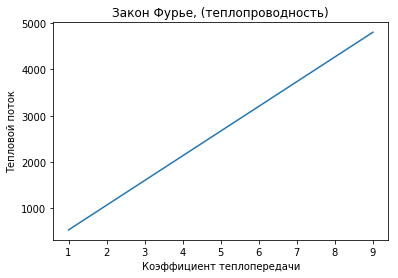

In [7]:
x=np.asarray(range(1,10))
y=q_conduction(10,x,0.9,0.8,20,10)
plt.plot(x,y)
plt.title('Закон Фурье, (теплопроводность)')
plt.xlabel('Коэффициент теплопередачи')
plt.ylabel('Тепловой поток')
plt.show()   



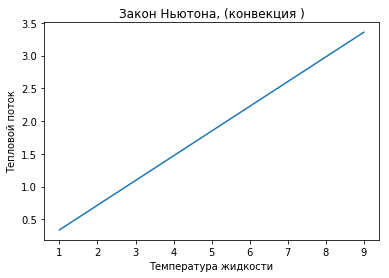

In [8]:
x=np.asarray(range(1,10))
y=q_convection(0.06,1,1,x,0.1)
plt.plot(x,y)
plt.title('Закон Ньютона, (конвекция )')
plt.xlabel('Температура жидкости')
plt.ylabel('Тепловой поток')
plt.show()   

## Исходные данные

In [9]:
depth_m=2560  #глубина скважины
rto_m=73/2/1000 #внешний радиус НКТ
rti_m=61/2/1000 #внутренний радиус НКТ
rcasi_m=120/2/1000 #внутренний радиус ОК
rcaso_m=143/2/1000 #внешний радиус ОК
rwb_m=300/2/1000 #внешний радиус скважины (после цемента)

teibh_c=80 #начальная пластовая температура на забое

geoterm_gradm=0.03 #геотермический градиент, С/м


ke_dsmc=2.4 #Теплопроводность породы, Дж/сек/м/С
kcem_dsmc=4 #Теплопроводность цемента, Дж/сек/м/С
kt_dsmc=30 #Теплопроводность металла, Дж/сек/м/С
kaliq_dsmc=200 #conductivity of annular fluid, ???
#Теплопередача за счет конвекции через жидкость Дж/сек/м2/С ???
kagas_dsmc=20 #Теплопередача за счет конвекции через газ Дж/сек/м2/С ???

rho_env_kgm3=4000 #плотность горных пород, кг/м3

rho_oil_kgm3=860
rho_water_kgm3=1000
cp_oil=2100 #теплоемкость нефти, Дж/кг/С
cp_water=4100 #теплоемкость воды, Дж/кг/С
cp_env=200 #теплоемкость горных пород, Дж/кг/С

qoil_m3day=60





In [10]:
dh=np.asarray(range(0,depth_m,10)) #Массив глубины по стволу скважины
tei1=(dh[-1]-dh)*geoterm_gradm*(-1)+teibh_c #Температура пласта по стволу в нач.усл.

## Функции

In [11]:
def td(t,ke=ke_dsmc,rhoe=rho_env_kgm3,cp_env=cp_env,rwb_m=rwb_m): #безразмерное время
    result=ke*t/(rhoe*cp_env*(math.pow(rwb_m,2)))
    return result
def rd(r): #безразмерное расстояние
    result=r/rwb_m
    return result
def Td(td): #безразмерная температура
    return math.log(math.exp(-0.2*td)+(1.5-0.3719*math.exp(-td))*math.sqrt(td))

def Lr(uto,w,td): #relaxation lenth parameter, 
    return 2*pi*rto_m*uto*ke_dsmc/(cp_env*w)/(ke_dsmc+rto_m*uto*td)
def reversed_uto(hto,hc,hr): #обратный коэффициет теплопередачи  ???
    first_part=rto_m/rti_m/hto #теплоотдача от ж к внутренней стенки НКТ
    second_part=rto_m*math.log(rto_m/rti_m)/kt_dsmc #теплопередача через стенку НКТ
    third_part=0
    fourth_part=rto_m/rto_m/(hc+hr) #теплоотдача от стенки НКТ ???
    fifth_part=rto_m*math.log(rcaso_m/rcasi_m)/kt_dsmc #теплопередача через стенку ОК 
    sixth_part=rto_m*math.log(rwb_m/rcaso_m)/kcem_dsmc #теплопередача через цементное кольцо
    return first_part+second_part+third_part+fourth_part+fifth_part+sixth_part
def w(q,rho): # массовый расход, кг/сек
    return q/86400*rho
def number_gr(rho,betta,delta_t,d,mu): #число Грасгофа
    return rho**2*betta*g*delta_t*d**3/mu**2
def number_pr(cp,mu,k): #число Прандтля
    return cp*mu/k
def number_nu(h,d,k): #число Нуссельта
    return h*d/k
def number_re(rho,v,d,mu): #число Рейнольдса
    return rho*v*d/mu
def number_nu_corr(n_re,n_pr): #корреляция для определения числа Нуссельта
    return 0.023*n_re**0.8*n_pr**0.3

def uto(hf,han,tempd,rti_m,rto_m,rcaso_m,rcasi_m,rwb_m,ke_dsmc,kcem_dsmc,kt_dsmc): #общий коэффициет теплопередачи
    first_part=1/rti_m/hf #теплоотдача от ж к внутренней стенки НКТ
    #out('first_part',first_part)
    second_part=math.log(rto_m/rti_m)/kt_dsmc/2 #убрать 2- ошибка #теплопередача через стенку НКТ
    #out('second_part',second_part)
    third_part=1/rcasi_m/han # конвекция через затруб
    #out('third_part',third_part)
    fourth_part=math.log(rcaso_m/rcasi_m)/kt_dsmc/2 #убрать 2- ошибка #теплопередача через стенку ОК 
    #out('fourth_part',fourth_part)
    fifth_part=math.log(rwb_m/rcaso_m)/kcem_dsmc #теплопередача через цементное кольцо
    #out('fifth_part',fifth_part)
    sixth_part=tempd/ke_dsmc #теплопередача через цементное кольцо
    #out('sixth_part',sixth_part)
    return 1/(first_part+second_part+third_part+fourth_part+fifth_part+sixth_part)/rto_m
def out(a,b,c=''):
    print(str(a) + ' = ' + str(b)+' --'+str(c) )

def tempd(td): #f(t)
    if td<=1.5:
        return 1.1281*math.sqrt(td)*(1-0.3*math.sqrt(td))
    elif td>1.5:
        return (0.4063+1/2*math.log(td))*(1+0.6/td)
    
def hf(ql,qg,rhol,rhog,mul,mug,kl,kg,cpl,cpg,d=rti_m*2):
    ap=pi/4*d**2
    vsl=ql/ap
    vsg=qg/ap
    vm=vsl+vsg
    llambda=vsl/vm
    rhon=rhol*llambda+rhog*(1-llambda)
    mun=mul*llambda+mug*(1-llambda)
    kn=kl*llambda+kg*(1-llambda)
    cpn=(cpl*rhol*llambda+cpg*rhog*(1-llambda))/rhon
    nren=number_re(rhon,vm,d,mun)
    nprn=number_pr(cpn,mun,kn)
    nnu=number_nu_corr(nren,nprn)
    return nnu*kn/d

def han(muan,cpan,kan,tto,tci,rhoan,betta,rci,rto):
    npr=number_pr(cpan,muan,kan)
    ngr=number_gr(rhoan,betta,(tto-tci),(rci-rto),muan)
    han=0.049*(ngr*npr)**(1/3)*npr**0.074*kan/(rto*math.log(rci/rto))
    han=0.25*han
    return han
    

def fc(pwh,mt,rp,gamma_api,gamma_gas,gg): #???????
    return ((-2.978)*10**(-3)+1.006*10**(-6)*pwh+1.906*10**(-4)*mt-1.047*10**(-6)*rp+
            3.229*10**(-5)*gamma_api+4.009*10**(-3)*gamma_gas-0.3551*gg)
def func(qg,ql,rhon,vm,at,cpm,u,dto,fc,tei,gg,l):
    rp=qg/ql
    out('rp',rp)
    mt=rhon*vm*at
    out('mt',mt)
    
    a=mt*cpm/pi/dto/u
    out('a',a)
    out('tei',tei)
    out('gg',gg)
    out('a',a)
    out('l',l)
    out('g',g)
    out('cpm',cpm)
    out('fc',fc)
    return (tei-gg*l)+a*(1-math.exp(-l/a))*(gg-g/cpm+fc)
    

In [12]:
#td(t,ke=ke_dsmc,rhoe=rho_env_kgm3,cp_env=cp_env)
val_td=td(2*7*24*3600,2.42,2504,1256,0.1079)
out('Dimensionless time',val_td,'безразмерное время')
val_tempd=tempd(val_td)
out('Dimensionless temperature',val_tempd,'безразмерная температура (f(t))')
val_hf=hf(79.5/86400,283/86400,882.9,80.3,0.015,1.5*10**(-4),0.138,1.73*10**(-4),2512,2093,0.0259*2)
out('hf, коэффициент теплоотдачи от ж к стенки НКТ',val_hf,'от жидкости к стенке НКТ')
val_han=han(0.0001,1004.81,0.865,6,3,36.92,0.004824,0.0797,0.0561)
out('han, коэффициент теплоотдачи в затрубном пространстве',val_han,'от жидкости к стенке НКТ')
rti_m=0.0259
rto_m=0.0561
rcaso_m=0.0889
rcasi_m=0.0797
rwb_m=0.108
kcem_dsmc=0.779
kt_dsmc=25
ke_dsmc=2.422
val_uto=uto(val_hf,val_han,val_tempd,rti_m,rto_m,rcaso_m,rcasi_m,rwb_m,ke_dsmc,kcem_dsmc,kt_dsmc)
out('U, общий коэффициент теплопередачи',val_uto,'с итерациями')
pwh=115
mt=2.37
rp=20
gamma_gas=0.65
gg=0.015
gamma_api=29
val_fc=fc(pwh,mt,rp,gamma_api,gamma_gas,gg)
out('F(c)',val_fc,'корреляция. в дурацких единицах')
val_fc=fc(pwh,mt,rp,gamma_api,gamma_gas,gg)/1.8/0.3048
out('F(c)',val_fc,'корреляция. в СИ')
tei=93.3 #1
gg=0.027 #2
ql=79.5 #3
qg=283 #4

l=1000

#def func(qg,ql,rhon,vm,at,cpm,u,dto,fc,tei,gg,l):
val_func= func(qg/86400,ql/86400,256.2,1.99,0.00211,2409.6,val_uto,0.0561*2,val_fc,tei,gg,l)
out('tf',val_func,'температура на устье')
val_func= func(283/86400,79.5/86400,256.2,1.99,0.00211,2409.6,6.73,0.0561*2,-0.00768,93.3,0.027,1000)
out('tf',val_func,'температура на устье')
print((93.3-0.027*1000)+1092.5*(1-math.exp(-1000/1092.5))*(0.027-9.8/2409.6-0.00768))
out('a',a)
print((tei-gg*l)+a*(1-math.exp(-l/1092.5))*(gg-g/2409.6-0.00768))
print((93.3-0.027*1000)+1122.17*(1-math.exp(-1000/1122.17))*(0.027-9.8/2409.6-0.00768))
print('Ошибка в расчетах либо в примере книги')

Dimensionless time = 79.94481297101623 --безразмерное время
Dimensionless temperature = 2.6164589869053594 --безразмерная температура (f(t))
hf, коэффициент теплоотдачи от ж к стенки НКТ = 93.6571017668145 --от жидкости к стенке НКТ
han, коэффициент теплоотдачи в затрубном пространстве = 14.180994340762789 --от жидкости к стенке НКТ
U, общий коэффициент теплопередачи = 6.7397795248285295 --с итерациями
F(c) = -0.004215768000000001 --корреляция. в дурацких единицах
F(c) = -0.00768403324584427 --корреляция. в СИ
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.1166729582117 --
tei = 93.3 --
gg = 0.027 --
a = 1091.1166729582117 --
l = 1000 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
tf = 76.28162242194075 --температура на устье
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1092.7022008325084 --
tei = 93.3 --
gg = 0.027 --
a = 1092.7022008325084 --
l = 1000 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768 --
tf = 76.28990413562484 --температура на устье


In [13]:
a=-0.00421
aa=a/1.8/0.3048
#print(out('kl;',a))
#tf=func(qg/86400,ql/86400,256.2,1.99,0.00211,2409.6,0.0561*2,val_uto,val_fc,tei,gg,l)
tfff=[]
tffg=[]
for i in range(0,depth_m,10):
    tf=func(qg/86400,ql/86400,256.2,1.99,0.00211,2409.6,0.0561*2,val_uto,val_fc,tei,gg,i)
    tfff.append(tf)
    tg=tei-gg*i
    tffg.append(tg)
l=list(range(0,depth_m,10))
#print(tff)

rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 0 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 10 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 20 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 30 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 40 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.5597

g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 870 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 880 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 890 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 900 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 910 --
g = 9

mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 1810 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 1820 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 1830 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 1840 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 1850 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --


l = 2360 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 2370 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 2380 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 2390 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --
l = 2400 --
g = 9.81 --
cpm = 2409.6 --
fc = -0.00768403324584427 --
rp = 3.559748427672956 --
mt = 1.0757581799999998 --
a = 1091.116672958212 --
tei = 93.3 --
gg = 0.027 --
a = 1091.116672958212 --


In [14]:
plot = figure(title='Распределение температуры',
               x_axis_label='Tемпература, °C',
               y_axis_label='Абсолютная глубина (TVD),м',
              #y_range=(dh[-1],dh[0]),
              
            )
plot.line(tfff,l,legend='Геотерма')
plot.line(tei1,l,legend='Геотерма')
show(plot)               

In [15]:

plot = figure(title='Распределение температуры',
               x_axis_label='Tемпература, °C',
               y_axis_label='Глубина от забоя,м',
              #y_range=(l[-1],l[0]),
              
              
            )
#plot.line(tei,dh,legend='Геотерма')
plot.line(tfff,l,color='red',legend='Температура флюида')
plot.line(tff,l,color='black',legend='Температура флюида2')
plot.line(tei1,dh,legend='Геотерма')
plot.line(tfg,l,legend='Геотерма2')
plot.line(tffg,l,legend='Геотерма')
show(plot)               

NameError: name 'tff' is not defined

In [4]:
#convective heat transfer in an Oil Well
ql_m3sec=79.5/86400 
qg_m3sec=283/86400
kl_wmc=0.138
kg_wmc=1.73*10**(-4)
rhol_kgm3=882.9
rhog_kgm3=80.3
cpl_jkgc=2512
cpg_jkgc=2093
mul_pas=0.015
mug_pas=1.5*10**(-4)
rti_m=0.0259

#natural convection in well annulus
rto_m=0.0561
rci_m=0.0797
#parametres are medium
mu_an_pas=0.0001
cp_an_jkgc=1004.81
rho_an_km3=36.92
k_an_wmc=0.865
betta_1c=0.004824

#overall heat transfer coefficient
rco_m=0.0889
rwb_m=0.1079
kcem_wmc=0.779
kt_wmc=25
ke_wmc=2.422

#
time_sec=100*7*24*3600
rhoe_kgm3=2504
cpe_jkgc=1256


tei_c=93.3
distance_m=1000
gg_cm=0.027
gamma_gas=0.65
gamma_api=29
p_pa=792.9*10**3

pwh=115

In [52]:
class Save_temp_fluid_c(object):
    """
    Класс для сохранения значений температуры внутри функции
    temp_fluid, в которой решения выполняются итеративно
    с помощью fsolve()
    """
 
    def __init__(self, init):
        """
        Начальное значение температуры
        """
        self.temp_fluid_c = init

    def save(self,value):
        """
        Сохранение вычисленных значений T в класс
        """
        self.temp_fluid_c=value


def fc_var2(p_pa,mt_kgs,rp_sm3sm3,gamma_api,gamma_gas,gg_cm):
    """
    Корреляция Sagar et al. (1991) для расчетра Fc
    физически - совокупность влияния эффекта Джоуля-Томпсона и
    изменения кинетической энергии на теплоперенос
    p_pa - давление, Па
    mt_kgs - массовый расход, кг/с
    rp_sm3sm3 - газовый фактор, м3/м3 ???
    gamma_api - плотность нефти, АPI
    gamma_gas - относительная плотность газа (по воздуху???)
    gg_cm - геотермический градиент, градус Цельсия на м 
    """    
    p_psi=p_pa/6894.757293178
    gg_fft=gg_cm/1.82268883056
    rp_scfstb=rp_sm3sm3/0.17810760667903497
    mt_lbms=mt_kgs*2.2046226218487757 #TODO проверить
    
    result_fft= ((-2.978)*10**(-3)+1.006*10**(-6)*p_psi+1.906*10**(-4)*mt-1.047*10**(-6)*rp_scfstb+
            3.229*10**(-5)*gamma_api+4.009*10**(-3)*gamma_gas-0.3551*gg_fft)
    return result_fft*1.82268883056

def han_var2(muan,cpan,kan,delta_temp_an,rhoan,betta,rci,rto):
        npr=number_pr(cpan,muan,kan)
        ngr=number_gr(rhoan,betta,delta_temp_an,(rci-rto),muan)
        han=0.049*(ngr*npr)**(1/3)*npr**0.074*kan/(rto*math.log(rci/rto))
        han=0.25*han
        return han

def temp_fluid_c(qg,ql,rhon,vm,at,cpm,u,dto,fc,tei,gg,l):
    rp=qg/ql
    mt=rhon*vm*at 
    a=mt*cpm/pi/dto/u
    return (tei-gg*l)+a*(1-np.exp(-l/a))*(gg-g/cpm+fc)

def temp_diff_an(tr,gg,l,rto,u,tf,rti,han):
    t=tr-l*gg
    q=2*pi*rto*u*(tf-t)
    temp_diff_an=q/(2*pi*rti*han)
    return temp_diff_an


In [55]:

def temp_fluid(distance_m,p_pa,delta0=1):
    """
    Функция для построения КРТ.
    На вход может подаваться numpy - матрица
    distance_m - расстояние от забоя, м
    p_pa - давление, Па
    delta0 - начальное приближение перепада температур в затрубном пространестве
        для расчета функцией fsolve

    """
    data_temp=Save_temp_fluid_c(None) #экземляр класса для хранения вычисленных данных
    def temp_diff_an_iter(delta):
        
        ap=pi/4*(rti_m*2)**2
        vsl=ql_m3sec/ap
        vsg=qg_m3sec/ap
        vm=vsl+vsg
        llambda=vsl/vm
        rhon=rhol_kgm3*llambda+rhog_kgm3*(1-llambda)
        mun=mul_pas*llambda+mug_pas*(1-llambda)
        kn=kl_wmc*llambda+kg_wmc*(1-llambda)
        cpn=(cpl_jkgc*rhol_kgm3*llambda+cpg_jkgc*rhog_kgm3*(1-llambda))/rhon

        rp=qg_m3sec/ql_m3sec
        mt=rhon*vm*ap

        val_hf=hf(ql_m3sec,qg_m3sec,rhol_kgm3,rhog_kgm3,mul_pas,mug_pas,kl_wmc,kg_wmc,cpl_jkgc,cpg_jkgc,d=rti_m*2)
        val_han=han_var2(mu_an_pas,cp_an_jkgc,k_an_wmc,delta,rho_an_km3,betta_1c,rci_m,rto_m)
        val_td=td(time_sec,ke_wmc,rhoe_kgm3,cpe_jkgc,rwb_m)
        val_tempd=tempd(val_td)
        val_uto=uto(val_hf,val_han,val_tempd,rti_m,rto_m,rco_m,rci_m,rwb_m,ke_wmc,kcem_wmc,kt_wmc)
        val_fc=fc_var2(p_pa,mt,rp,gamma_api,gamma_gas,gg_cm)
        val_temp_fluid_c=temp_fluid_c(qg_m3sec,ql_m3sec,rhon,vm,ap,cpn,val_uto,rto_m*2,val_fc,tei_c,gg_cm,distance_m)
        data_temp.save((val_temp_fluid_c)) #сохранения в экземляр значений температуры
        val_temp_diff_an=temp_diff_an(tei_c,gg_cm,distance_m,rto_m,val_uto,val_temp_fluid_c,rti_m,val_han)
        result=val_temp_diff_an-delta
        return result
    delta=fsolve(temp_diff_an_iter,delta0)

    return data_temp.temp_fluid_c

In [56]:

print((temp_fluid(1,p_pa,1)))

[93.28845003]


In [57]:
help(temp_fluid)

Help on function temp_fluid in module __main__:

temp_fluid(distance_m, p_pa, delta0=1)
    Функция для построения КРТ.
    На вход может подаваться numpy - матрица
    distance_m - расстояние от забоя, м
    p_pa - давление, Па
    delta0 - начальное приближение перепада температур в затрубном пространестве
        для расчета функцией fsolve



In [58]:
a=1000*g*2550
b=10**6
c=a/depth_m
print(c)
print(b)
pbh_pa=a

9771.6796875
1000000


In [59]:
tff=[]
tfg=[]
p=[]
for i in range(1,depth_m,10):
    p_val=pbh_pa-c*i
    tf=temp_fluid(i,p_val,3)
    tff.append(tf)
    tg=tei-gg*i
    tfg.append(tg)
    p.append(p_val)
l=list(range(1,depth_m,10))

p=np.asarray(p)

tff=np.asarray(tff)
tfg=np.asarray(tfg)
p=np.asarray(p)
l=np.asarray(l)
mistake=p*0+1
tff=temp_fluid(l,p,mistake)
tff.shape
ql=np.asarray([10,30,50,100,150])
ql=ql/86400
plot = figure(title='Распределение температуры',
               x_axis_label='Tемпература, °C',
               y_axis_label='Глубина от забоя,м')
kk=['red','green','blue','yellow','black']
for i,k in zip(ql,kk):
    ql_m3sec=i
    tff=temp_fluid(l,p,mistake)
    legendd='Q='+str(i*86400)
    plot.line(tff,l,color=k,legend=legendd)
show(plot)
    

In [60]:
def make():
    plot = figure(title='Распределение температуры',
                   x_axis_label='Tемпература, °C',
                   y_axis_label='Глубина от забоя,м',


                )
    plot.line(tff,l,color='red',legend='Температура флюида')
    plot.line(tfg,l,legend='Геотерма')
    plot.line(p/10**5,l,legend='Давление, атм',color='black')
    show(plot)
show(plot) 
make()